# Pay Type Predictor (Classification)

The goal of this project is trying to build an algorithm to automatically test if a given payment information description belongs to the following three categories respectively: `is_productive`, `use_salaries`, and `use_hours`. These categories are independent, which means a specific payment can belong to more than one categories. 

In [1]:
ls data

README.md                 paycode_data.xlsx         paycode_first_clean.xlsx


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1 - Data Preprocessing

Read Data: 

In [3]:
data = pd.read_excel('data/paycode_data.xlsx')
data.head()

,report_id,pay_type_id,pay_type_description,Total_Dollars,Total_Hours,Hourly Rate,cr255210db1_pay_pay_types.is_productive,cr255210db1_pay_pay_types.use_salaries,cr255210db1_pay_pay_types.use_hours
0,87,101,MISC-REGULAR,93339554.0,2679091.0,34.840009,1,1,1
1,87,102,MISC-SICK PAY,5258853.0,158087.0,33.265563,0,1,1
2,87,104,MISC-VACATION,6710429.0,196136.0,34.213143,0,1,1
3,87,105,MISC-OTHER TIMEOFF,10103587.0,289865.0,34.856181,0,1,1
4,87,201,UNIFORM-REGULAR,5080.0,180.0,28.222222,1,1,1


In [4]:
data = data.drop(columns = ["report_id","pay_type_id" ])

The last three column names seems a little messy. We can rename them: 

In [5]:
data.columns = ['pay_type_description', 'total_dollars', 'total_hours', 'hourly_rate', 'is_productive', 'use_salaries', 'use_hours']
data.head()

,pay_type_description,total_dollars,total_hours,hourly_rate,is_productive,use_salaries,use_hours
0,MISC-REGULAR,93339554.0,2679091.0,34.840009,1,1,1
1,MISC-SICK PAY,5258853.0,158087.0,33.265563,0,1,1
2,MISC-VACATION,6710429.0,196136.0,34.213143,0,1,1
3,MISC-OTHER TIMEOFF,10103587.0,289865.0,34.856181,0,1,1
4,UNIFORM-REGULAR,5080.0,180.0,28.222222,1,1,1


# Step 2 - Split Data into Training and Testing

In [6]:
total = len(data)
total

62391

We'll just use the 80/20 ratio for training and testing: 

In [7]:
train = data.iloc[ : int(total*0.8)]
train.head()

,pay_type_description,total_dollars,total_hours,hourly_rate,is_productive,use_salaries,use_hours
0,MISC-REGULAR,93339554.0,2679091.0,34.840009,1,1,1
1,MISC-SICK PAY,5258853.0,158087.0,33.265563,0,1,1
2,MISC-VACATION,6710429.0,196136.0,34.213143,0,1,1
3,MISC-OTHER TIMEOFF,10103587.0,289865.0,34.856181,0,1,1
4,UNIFORM-REGULAR,5080.0,180.0,28.222222,1,1,1


In [8]:
train.tail()

,pay_type_description,total_dollars,total_hours,hourly_rate,is_productive,use_salaries,use_hours
49907,B12 BNS RET 12,10000.00,0.0,0.0,0,1,0
49908,BN9 BNS OTS,308285.00,0.0,0.0,0,1,0
49909,BNA BNSANNUAL,7062.64,0.0,0.0,0,1,0
49910,BNC BNSQUARTER,550.00,0.0,0.0,0,1,0
49911,BNE BNSSODOH,50000.00,0.0,0.0,0,1,0


In [9]:
test = data.iloc[int(total*0.8):]
test.head()

,pay_type_description,total_dollars,total_hours,hourly_rate,is_productive,use_salaries,use_hours
49912,CEC MISCCOMP,8898.83,0.0,0.0,0,1,0
49913,Imputed Income,12627.00,0.0,0.0,0,1,0
49914,Med Direct,9100.00,0.0,0.0,0,1,0
49915,CHO HOUSECLRG,38736.00,0.0,0.0,0,1,0
49916,PT2 EIB,18502.45,0.0,0.0,0,1,0


# Step 3 - Classifier by Separability

<h3> 1. Total Dollars </h3>

There might be some correlation between the total dollar amount and the categories. So let's run some tests and see. 

<h3 style="color:green"> total_dollars vs is_productive </h3>

### Training (Learning) 

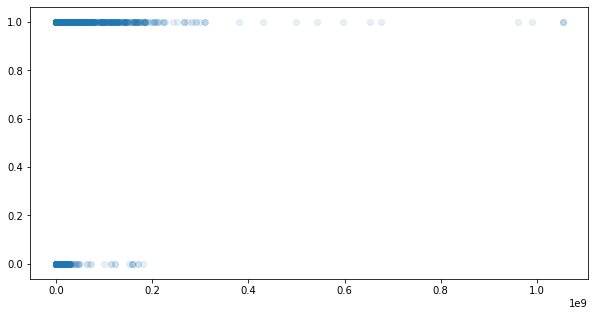

In [10]:
fig = plt.figure(figsize=(10, 5))
plt.scatter(x = train.total_dollars, y = train.is_productive, alpha = 0.1)

It seems like that when the dollar amount gets large enough, it will fall into 1 (meaning IS productive). Let's find out more about the threshold. 

In [11]:
max_not_productive_amount = max(train[train.is_productive == 0].total_dollars)
max_not_productive_amount

181240153.41

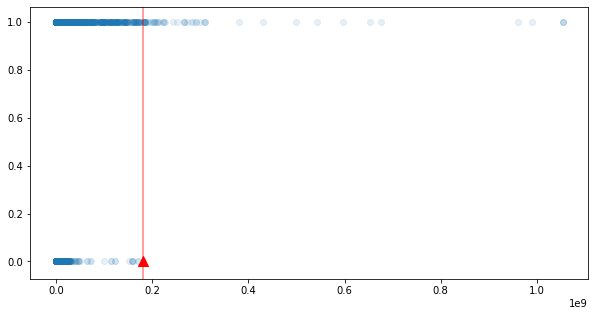

In [12]:
fig = plt.figure(figsize=(10, 5))
plt.scatter(x = train.total_dollars, y = train.is_productive, alpha = 0.1)
plt.scatter(max_not_productive_amount, 0, marker = '^', c = "red", s = 100) 
plt.axvline(x = max_not_productive_amount, color = "red", alpha = 0.5)

Which means that to the right of the red verticle line, the payment is very likely productive. 

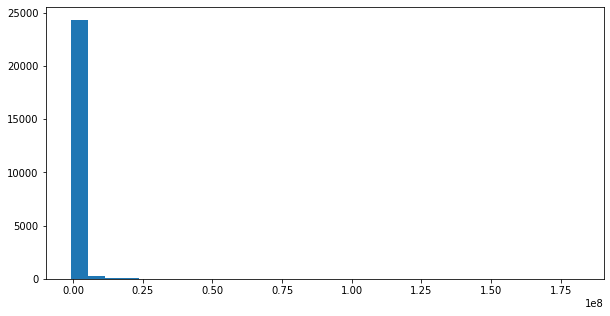

In [13]:
fig = plt.figure(figsize=(10, 5))
plt.hist(train[train.is_productive == 0].total_dollars, bins = 30); 

In [14]:
np.percentile(a = train[train.is_productive == 0].total_dollars, q = [25, 50, 75, 80, 90, 95])

array([   1893.46 ,   22893.49 ,  158085.16 ,  249589.368,  757784.136,
       1806148.05 ])

In [15]:
np.percentile(a = train[train.is_productive == 0].total_dollars, q = [99.9, 99.91, 99.92])

array([38455612.83772235, 41870477.160404  , 45303660.98975977])

We can set the approximate threshold value to be $45303660, marked by the green triangle in the graph below. Anything above that can be classified as `is_productive`. 

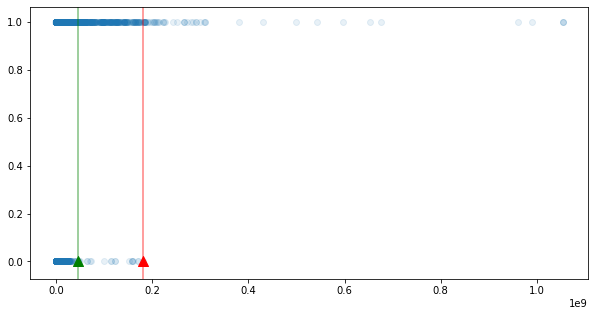

In [16]:
fig = plt.figure(figsize=(10, 5))
plt.scatter(x = train.total_dollars, y = train.is_productive, alpha = 0.1)
plt.scatter(max_not_productive_amount, 0, marker = '^', c = "red", s = 100) 
plt.axvline(x = max_not_productive_amount, color = "red", alpha = 0.5)
plt.scatter(45303660, 0, marker = '^', c = "green", s = 100) 
plt.axvline(x = 45303660, color = "green", alpha = 0.5)

### Testing

In [17]:
def testing(threshold, x_attribute, y_attribute):
    prediction = []
    if x_attribute == "total_dollars":
        test_x = test.total_dollars
    elif x_attribute == "total_hours":
        test_x = test.total_hours
    elif x_attribute == "hourly_rate":
        test_x = test.hourly_rate
    else:
        print("ERROR: x_attribute is not recognized")
        
    for amount in test_x:
        if amount > threshold: 
            prediction.append(1)
        else:
            prediction.append(0)
    
    count = len(prediction)
    if y_attribute == "is_productive": 
        truth = list(test.is_productive)
    elif y_attribute == "use_salaries":
        truth = list(test.use_salaries)
    elif y_attribute == "use_hours":
        truth = list(test.use_hours)
    else:
        print("ERROR: y_attribute is not recognized")
    correct_count = 0 
    for i in range(count):
        if prediction[i] == truth[i]:
            correct_count += 1
    print("The correct rate of classifier is: ", correct_count / count)

In [18]:
testing(45303660, "total_dollars", "is_productive")

The correct rate of classifier is:  0.5629457488580816


<h3 style="color:green"> total_dollars vs use_salaris </h3>

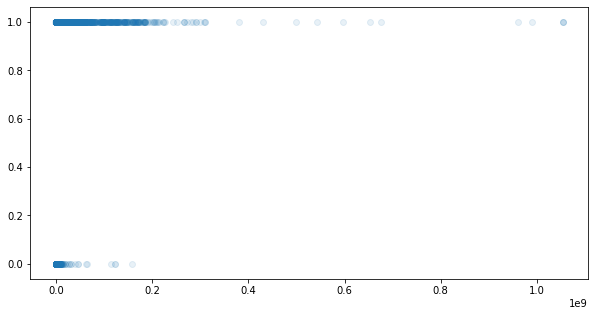

In [19]:
fig = plt.figure(figsize=(10, 5))
plt.scatter(x = train.total_dollars, y = train.use_salaries, alpha = 0.1)

Okay, seems like a better correlation. 

In [20]:
threshold = np.percentile(a = train[train.use_salaries == 0].total_dollars, q = 99.7)
threshold

13888459.426900025

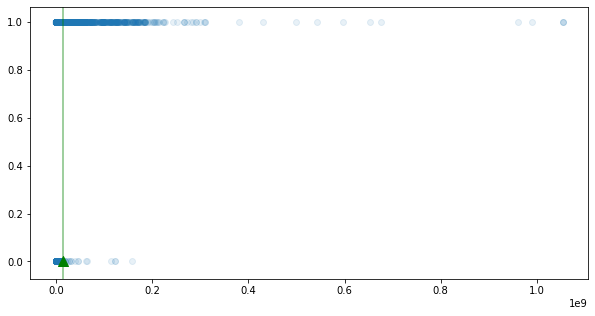

In [21]:
fig = plt.figure(figsize=(10, 5))
plt.scatter(x = train.total_dollars, y = train.use_salaries, alpha = 0.1)
plt.scatter(threshold, 0, marker = '^', c = "green", s = 100) 
plt.axvline(x = threshold, color = "green", alpha = 0.5)

In [22]:
testing(threshold, "total_dollars", "use_salaries")

The correct rate of classifier is:  0.18551165958810803


Whoa, okay. Very bad. 

<h3 style="color:green"> total_dollars vs use_hours </h3>

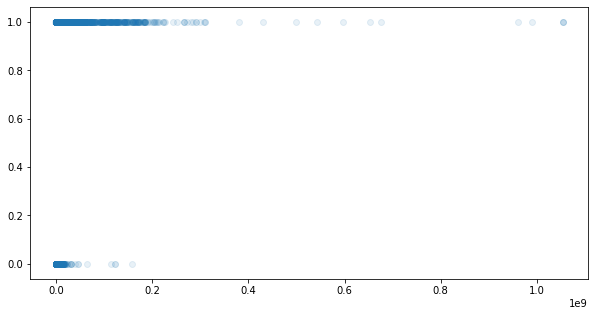

In [23]:
fig = plt.figure(figsize=(10, 5))
plt.scatter(x = train.total_dollars, y = train.use_hours, alpha = 0.1)

The graph looks very similar to the total_dollars vs use_salaries graph. So it's probably not seperable. 

<h3> 2. Total Hours </h3>

<h3 style="color:green"> total_hours vs is_productive </h3>

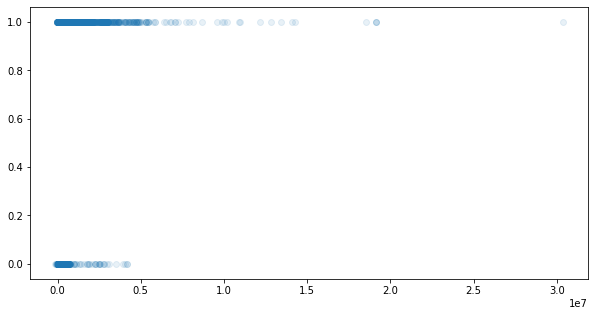

In [24]:
fig = plt.figure(figsize=(10, 5))
plt.scatter(x = train.total_hours, y = train.is_productive, alpha = 0.1)

<h3 style="color:green"> total_hours vs use_salaries </h3>

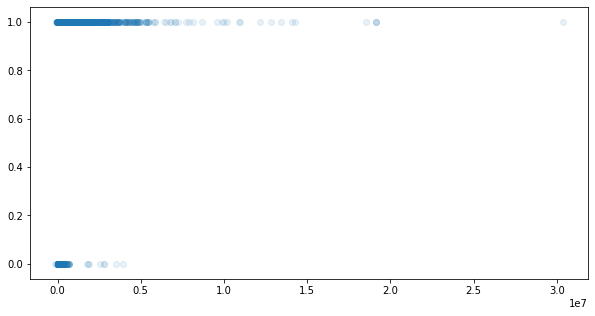

In [25]:
fig = plt.figure(figsize=(10, 5))
plt.scatter(x = train.total_hours, y = train.use_salaries, alpha = 0.1)

<h3 style="color:green"> total_hours vs use_hours </h3>

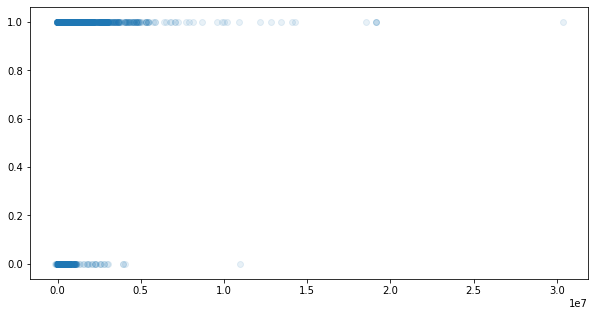

In [26]:
fig = plt.figure(figsize=(10, 5))
plt.scatter(x = train.total_hours, y = train.use_hours, alpha = 0.1)

<h3> 3. Hourly Rate </h3>

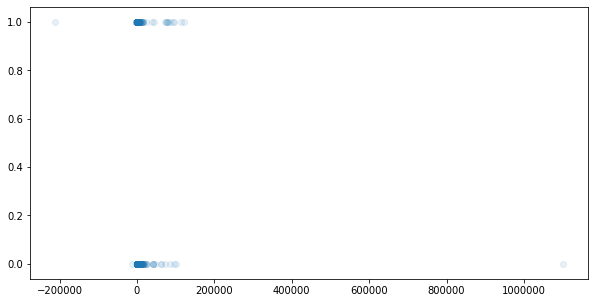

In [27]:
fig = plt.figure(figsize=(10, 5))
plt.scatter(x = train.hourly_rate, y = train.is_productive, alpha = 0.1)

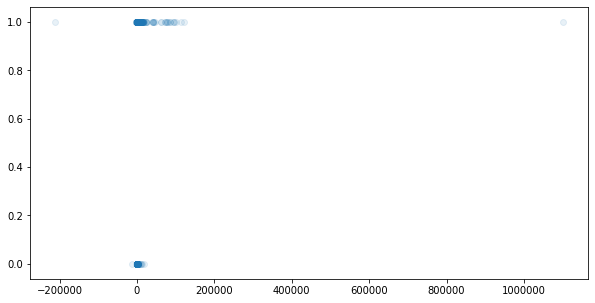

In [28]:
fig = plt.figure(figsize=(10, 5))
plt.scatter(x = train.hourly_rate, y = train.use_salaries, alpha = 0.1)

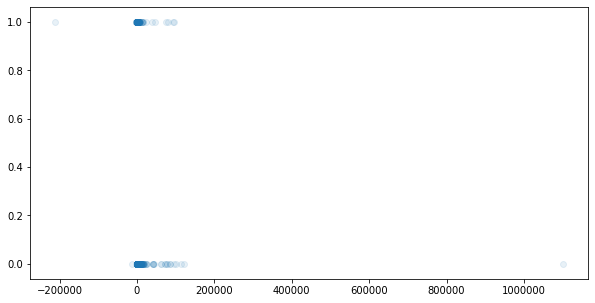

In [29]:
fig = plt.figure(figsize=(10, 5))
plt.scatter(x = train.hourly_rate, y = train.use_hours, alpha = 0.1)

# Step 4 - Machine Learning Classifier based on total_dollars, total_hours, and hourly_rate all together

In [30]:
from tensorflow import keras
import tensorflow as tf
from keras import regularizers
from sklearn import preprocessing

Using TensorFlow backend.


In [31]:
data.head()

,pay_type_description,total_dollars,total_hours,hourly_rate,is_productive,use_salaries,use_hours
0,MISC-REGULAR,93339554.0,2679091.0,34.840009,1,1,1
1,MISC-SICK PAY,5258853.0,158087.0,33.265563,0,1,1
2,MISC-VACATION,6710429.0,196136.0,34.213143,0,1,1
3,MISC-OTHER TIMEOFF,10103587.0,289865.0,34.856181,0,1,1
4,UNIFORM-REGULAR,5080.0,180.0,28.222222,1,1,1


As we can see, the values in `total_dollars` and `total_hours` can get very large, so it's better to scale the data first to avoid bias later on. 

Note: It is probably not a good idea to standardize the data, since, as we can see from the graphs above, the distributions do not look very "normal". 

In [32]:
min_max_scaler = preprocessing.MinMaxScaler()

In [33]:
data["total_dollars_scaled"] = min_max_scaler.fit_transform(data[["total_dollars"]])
data["total_hours_scaled"] = min_max_scaler.fit_transform(data[["total_hours"]])
data["hourly_rate_scaled"] = min_max_scaler.fit_transform(data[["hourly_rate"]])
data.head()

,pay_type_description,total_dollars,total_hours,hourly_rate,is_productive,use_salaries,use_hours,total_dollars_scaled,total_hours_scaled,hourly_rate_scaled
0,MISC-REGULAR,93339554.0,2679091.0,34.840009,1,1,1,0.086697,0.092102,0.311850
1,MISC-SICK PAY,5258853.0,158087.0,33.265563,0,1,1,0.009987,0.009415,0.311849
2,MISC-VACATION,6710429.0,196136.0,34.213143,0,1,1,0.011251,0.010662,0.311850
3,MISC-OTHER TIMEOFF,10103587.0,289865.0,34.856181,0,1,1,0.014207,0.013737,0.311850
4,UNIFORM-REGULAR,5080.0,180.0,28.222222,1,1,1,0.005412,0.004235,0.311846


In [34]:
data = data.drop(["total_dollars", "total_hours", "hourly_rate"], axis = 1); 
data.head()

,pay_type_description,is_productive,use_salaries,use_hours,total_dollars_scaled,total_hours_scaled,hourly_rate_scaled
0,MISC-REGULAR,1,1,1,0.086697,0.092102,0.311850
1,MISC-SICK PAY,0,1,1,0.009987,0.009415,0.311849
2,MISC-VACATION,0,1,1,0.011251,0.010662,0.311850
3,MISC-OTHER TIMEOFF,0,1,1,0.014207,0.013737,0.311850
4,UNIFORM-REGULAR,1,1,1,0.005412,0.004235,0.311846


Now, after scaling, again, we split the data into training and testing:

In [35]:
train = data.iloc[ : int(total*0.8)]
train.head()

,pay_type_description,is_productive,use_salaries,use_hours,total_dollars_scaled,total_hours_scaled,hourly_rate_scaled
0,MISC-REGULAR,1,1,1,0.086697,0.092102,0.311850
1,MISC-SICK PAY,0,1,1,0.009987,0.009415,0.311849
2,MISC-VACATION,0,1,1,0.011251,0.010662,0.311850
3,MISC-OTHER TIMEOFF,0,1,1,0.014207,0.013737,0.311850
4,UNIFORM-REGULAR,1,1,1,0.005412,0.004235,0.311846


In [36]:
train.tail()

,pay_type_description,is_productive,use_salaries,use_hours,total_dollars_scaled,total_hours_scaled,hourly_rate_scaled
49907,B12 BNS RET 12,0,1,0,0.005416,0.004229,0.311828
49908,BN9 BNS OTS,0,1,0,0.005676,0.004229,0.311828
49909,BNA BNSANNUAL,0,1,0,0.005413,0.004229,0.311828
49910,BNC BNSQUARTER,0,1,0,0.005408,0.004229,0.311828
49911,BNE BNSSODOH,0,1,0,0.005451,0.004229,0.311828


In [37]:
test = data.iloc[int(total*0.8):]
test.head()

,pay_type_description,is_productive,use_salaries,use_hours,total_dollars_scaled,total_hours_scaled,hourly_rate_scaled
49912,CEC MISCCOMP,0,1,0,0.005415,0.004229,0.311828
49913,Imputed Income,0,1,0,0.005418,0.004229,0.311828
49914,Med Direct,0,1,0,0.005415,0.004229,0.311828
49915,CHO HOUSECLRG,0,1,0,0.005441,0.004229,0.311828
49916,PT2 EIB,0,1,0,0.005423,0.004229,0.311828


In [38]:
train_x = train[["total_dollars_scaled", "total_hours_scaled", "hourly_rate_scaled"]]
valid_x = test[["total_dollars_scaled", "total_hours_scaled", "hourly_rate_scaled"]]

# train_x = train[["total_dollars_scaled"]]
# valid_x = test[["total_dollars_scaled"]]

train_y_is_productive = train[["is_productive"]]
valid_y_is_productive = test.is_productive

train_y_use_salaries = train[["use_salaries"]]
valid_y_use_salaries = test.use_salaries

train_y_use_hours = train[["use_hours"]]
valid_y_use_hours = test.use_hours

In [39]:
train_x.head()

,total_dollars_scaled,total_hours_scaled,hourly_rate_scaled
0,0.086697,0.092102,0.311850
1,0.009987,0.009415,0.311849
2,0.011251,0.010662,0.311850
3,0.014207,0.013737,0.311850
4,0.005412,0.004235,0.311846


In [40]:
valid_x.head()

,total_dollars_scaled,total_hours_scaled,hourly_rate_scaled
49912,0.005415,0.004229,0.311828
49913,0.005418,0.004229,0.311828
49914,0.005415,0.004229,0.311828
49915,0.005441,0.004229,0.311828
49916,0.005423,0.004229,0.311828


In [41]:
type(train.is_productive)

pandas.core.series.Series

<h2 style="color:green"> Multi-Layer Perceptron (Neural Network) </h2> 

In [42]:
model = keras.Sequential([
    # keras.layers.Dense(10, input_dim = 3, kernel_initializer ='normal', activation='relu', kernel_regularizer = keras.regularizers.l2(2)),
    
    keras.layers.Dense(10, input_dim = 3, activation='softmax'),            
    keras.layers.Dense(1000),
    keras.layers.Dense(1000),
    keras.layers.Dense(1, activation='softmax'),
])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [43]:
optimizer = keras.optimizers.Adagrad(lr = 1)
model.compile(optimizer = optimizer, loss='MSE')

model.fit(train_x, train_y_is_productive, epochs = 5, batch_size = 1000)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Epoch 1/5
49912/49912 [==============================] - 4s 74us/sample - loss: 0.4969
Epoch 2/5
49912/49912 [==============================] - 3s 65us/sample - loss: 0.4969
Epoch 3/5
49912/49912 [==============================] - 3s 66us/sample - loss: 0.4969
Epoch 4/5
49912/49912 [==============================] - 3s 66us/sample - loss: 0.4969
Epoch 5/5
49912/49912 [==============================] - 3s 65us/sample - loss: 0.4969


The loss barely changes. 

In [44]:
predictions = model.predict(valid_x)

In [45]:
predictions[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)

In [46]:
len(predictions)

12479

In [47]:
predictions = predictions.reshape((len(predictions), ))
valid_y_is_productive = list(valid_y_is_productive)

In [48]:
count = 0
temp = len(predictions)
for i in range(temp):
    if predictions[i] == valid_y_is_productive[i]:
        count += 1
print(count / temp)

0.44130138632903276


The Multi-Layer Perceptron model ended up giving us all '1's... Probably not a very good model. 

<h2 style="color:green"> Multilinear Regression</h2>

In [49]:
from sklearn.linear_model import LinearRegression

In [50]:
reg = LinearRegression().fit(train_x, train_y_is_productive)

In [51]:
print("Train regression score: ", str(reg.score(train_x, train_y_is_productive)))

Train regression score:  0.00474400804025088


The train regression score is so low already. Multilinear Regression is probably really bad too. 

<h2 style="color:green"> Random Forest</h2>

In [52]:
from sklearn.ensemble import RandomForestRegressor

In [53]:
rf = RandomForestRegressor(max_depth = 90, random_state = 0, n_estimators = 50)

In [54]:
rf.fit(train_x, train_y_use_hours)

/Users/changyuyan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=90,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [55]:
pred = rf.predict(valid_x)
train_pred = rf.predict(train_x)

pred = pred.reshape((len(pred), ))
train_pred = train_pred.reshape((len(train_pred), ))

pred = [round(x) for x in pred]
train_pred = [round(x) for x in train_pred]

In [56]:
sum(pred)

5578.0

In [57]:
count = 0
vy = list(valid_y_use_hours)
for i in range(temp):
    if pred[i] == vy[i]:
        count += 1
print(count / temp)

0.8532734994791249


In [58]:
count = 0
for i in range(len(train_pred)):
    if train_pred[i] == train_y_use_hours.use_hours[i]:
        count += 1
print(count / len(train_pred))

0.9131271037025164


In [59]:
import pickle

In [60]:
pwd

'/Users/changyuyan/Developer/Paytype-Classifier/Modeling'

In [61]:
cd ../Flask/models

/Users/changyuyan/Developer/Paytype-Classifier/Flask/models


In [62]:
!touch RandomForest.pkl

In [71]:
cd /Users/changyuyan/Developer/Paytype-Classifier/Modeling

/Users/changyuyan/Developer/Paytype-Classifier/Modeling


In [74]:
ls ../Flask/models

RandomForest.pkl


In [75]:
# save the model to disk
pickle.dump(rf, open('../Flask/models/RandomForest.pkl', 'wb'))

In [77]:
# Test if load works

rf_model = open("../Flask/models/RandomForest.pkl","rb")
rf = pickle.load(rf_model)

pred = rf.predict(valid_x)
train_pred = rf.predict(train_x)

pred = pred.reshape((len(pred), ))
train_pred = train_pred.reshape((len(train_pred), ))

pred = [round(x) for x in pred]
train_pred = [round(x) for x in train_pred]

count = 0
vy = list(valid_y_use_hours)
for i in range(temp):
    if pred[i] == vy[i]:
        count += 1
print(count / temp)

0.8532734994791249


In [78]:
entered = np.array([12, 123, 123])
entered = entered.reshape((1, -1))

In [79]:
rf.predict(entered)[0]

0.98